<div class="alert alert-block alert-success">
     
# IC PCDA CAPSTONE - HARRY BAKHSHI - NOTEBOOK 12 - COMBINING VALIDATION AND TEST SET FORECASTS BY "BEST FIT" METHOD
     
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.io as pio
import plotly.express as px
pio.templates.default = "plotly_white"
import pandas as pd
import pickle
import statistics
from darts.metrics import mase, mse, mae
from sklearn.preprocessing import StandardScaler
import time
import warnings
from src.utils.ts_utils import forecast_bias, darts_metrics_adapter
from src.utils.general import LogTime
from src.utils import plotting_utils
from src.forecasting.ml_forecasting import MissingValueConfig, FeatureConfig, ModelConfig, MLForecast, calculate_metrics

/Users/harrybakhshi/Desktop/Python_notes/Modern-Time-Series-Forecasting-with-Python-main/src/utils/data_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Import data:

In [2]:
#Import timeseries forecast data:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/ml_validation/metric_df_2.pik'
# with open(file, 'wb') as f:
#     pickle.dump(metric_df_val, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     metric_df_val = pickle.load(f) #load pickle file 'file' into variable
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/ml_validation/pred_df_2.pik'
# with open(file, 'wb') as f:
#     pickle.dump(pred_df_val, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     pred_df_val = pickle.load(f) #load pickle file 'file' into variable
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/ml_test/metric_df_2.pik'
# with open(file, 'wb') as f:
#     pickle.dump(metric_df_test, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     metric_df_test = pickle.load(f) #load pickle file 'file' into variable
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/ml_test/pred_df_2.pik'
# with open(file, 'wb') as f:
#     pickle.dump(pred_df_test, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     pred_df_test = pickle.load(f) #load pickle file 'file' into variable

In [3]:
#For formatting plots:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title="", figsize=(500,900), font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=figsize[1],
            height=figsize[0],
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/01-Visualizing%20Time%20Series.ipynb
#Accessed 06/06/2024

# FIND BEST MODEL AND BEST FIT, COMPARE

# Compare the median model metrics:

In [4]:
metric_df = metric_df_val
median_mae_list = []
median_mae_list.append(statistics.median(metric_df[metric_df['Linear Regression'] == 1]['MAE']))
median_mae_list.append(statistics.median(metric_df[metric_df['Lasso Regression'] == 1]['MAE']))
median_mae_list.append(statistics.median(metric_df[metric_df['Linear SVR'] == 1]['MAE']))
median_mae_list.append(statistics.median(metric_df[metric_df['XGB'] == 1]['MAE']))
median_mae_list.append(statistics.median(metric_df[metric_df['LightGBM'] == 1]['MAE']))
median_mae_list.append(statistics.median(metric_df[metric_df['Decision Tree'] == 1]['MAE']))
median_mae_list.append(statistics.median(metric_df[metric_df['Random Forest'] == 1]['MAE']))
median_mse_list = []
median_mse_list.append(statistics.median(metric_df[metric_df['Linear Regression'] == 1]['MSE']))
median_mse_list.append(statistics.median(metric_df[metric_df['Lasso Regression'] == 1]['MSE']))
median_mse_list.append(statistics.median(metric_df[metric_df['Linear SVR'] == 1]['MSE']))
median_mse_list.append(statistics.median(metric_df[metric_df['XGB'] == 1]['MSE']))
median_mse_list.append(statistics.median(metric_df[metric_df['LightGBM'] == 1]['MSE']))
median_mse_list.append(statistics.median(metric_df[metric_df['Decision Tree'] == 1]['MSE']))
median_mse_list.append(statistics.median(metric_df[metric_df['Random Forest'] == 1]['MSE']))
median_mase_list = []
median_mase_list.append(statistics.median(metric_df[metric_df['Linear Regression'] == 1]['MASE']))
median_mase_list.append(statistics.median(metric_df[metric_df['Lasso Regression'] == 1]['MASE']))
median_mase_list.append(statistics.median(metric_df[metric_df['Linear SVR'] == 1]['MASE']))
median_mase_list.append(statistics.median(metric_df[metric_df['XGB'] == 1]['MASE']))
median_mase_list.append(statistics.median(metric_df[metric_df['LightGBM'] == 1]['MASE']))
median_mase_list.append(statistics.median(metric_df[metric_df['Decision Tree'] == 1]['MASE']))
median_mase_list.append(statistics.median(metric_df[metric_df['Random Forest'] == 1]['MASE']))
median_fbias_list = []
median_fbias_list.append(statistics.median(metric_df[metric_df['Linear Regression'] == 1]['Forecast Bias']))
median_fbias_list.append(statistics.median(metric_df[metric_df['Lasso Regression'] == 1]['Forecast Bias']))
median_fbias_list.append(statistics.median(metric_df[metric_df['Linear SVR'] == 1]['Forecast Bias']))
median_fbias_list.append(statistics.median(metric_df[metric_df['XGB'] == 1]['Forecast Bias']))
median_fbias_list.append(statistics.median(metric_df[metric_df['LightGBM'] == 1]['Forecast Bias']))
median_fbias_list.append(statistics.median(metric_df[metric_df['Decision Tree'] == 1]['Forecast Bias']))
median_fbias_list.append(statistics.median(metric_df[metric_df['Random Forest'] == 1]['Forecast Bias']))
model_list = ['Linear Regression', 'Lasso Regression', 'Linear SVR', 'XGB', 'LightGBM', 'Decision Tree', 'Random Forest']
d = {'Model': model_list, 'Median MAE': median_mae_list, 'Median MSE': median_mse_list, 'Median MASE': median_mase_list, 'Median Forecast Bias': median_fbias_list}
df = pd.DataFrame(data=d)
df

,Model,Median MAE,Median MSE,Median MASE,Median Forecast Bias
0,Linear Regression,6.207416e+01,3.856081e+03,7.011926e+00,3.443542e+01
1,Lasso Regression,1.057853e+02,1.119522e+04,1.194956e+01,5.868405e+01
2,Linear SVR,1.469489e+02,2.159791e+04,1.659941e+01,8.151938e+01
3,XGB,3.139295e-04,2.972544e-07,3.546162e-05,1.411387e-04
4,LightGBM,1.797021e-01,4.815939e-02,2.029923e-02,-9.568705e-02
5,Decision Tree,1.136868e-13,1.292470e-26,1.284212e-14,-9.294140e-14
6,Random Forest,3.410605e-13,1.163223e-25,3.852635e-14,-1.991602e-13


## FIND BEST MODEL

In [5]:
best_list = []
for col in range(len(df.columns.values[1:])):
    column_list = list(df[df.columns.values[col + 1]])[1:]
    min_ = min(column_list, key=lambda x: abs(x - 0))
    for row in range(len(column_list)):
        if column_list[row] == min_:
            best_list.append(df['Model'][row + 1])
    #^https://medium.com/devcodef1com/match-lists-based-on-the-closest-value-in-python-5a0234548188#:~:text=Approach%202%3A%20Using%20the%20min()%20Function&text=The%20lambda%20function%20calculates%20the,which%20is%20the%20closest%20value.
    #Accessed 29/06/2024
d = {'Metric': ['Median MAE', 'Median MSE', 'Median MASE', 'Median Forecast Bias'], 'Best Model': best_list}
best_df = pd.DataFrame(data=d)
best_df

,Metric,Best Model
0,Median MAE,Decision Tree
1,Median MSE,Decision Tree
2,Median MASE,Decision Tree
3,Median Forecast Bias,Decision Tree


## FIND BEST FIT

In [6]:
best_fit = df.loc[5:, :]

In [7]:
metric_df = metric_df_test
median_mae_list = []
median_mae_list.append(statistics.median(metric_df[metric_df['Linear Regression'] == 1]['MAE']))
median_mae_list.append(statistics.median(metric_df[metric_df['Lasso Regression'] == 1]['MAE']))
median_mae_list.append(statistics.median(metric_df[metric_df['Linear SVR'] == 1]['MAE']))
median_mae_list.append(statistics.median(metric_df[metric_df['XGB'] == 1]['MAE']))
median_mae_list.append(statistics.median(metric_df[metric_df['LightGBM'] == 1]['MAE']))
median_mae_list.append(statistics.median(metric_df[metric_df['Decision Tree'] == 1]['MAE']))
median_mae_list.append(statistics.median(metric_df[metric_df['Random Forest'] == 1]['MAE']))
median_mse_list = []
median_mse_list.append(statistics.median(metric_df[metric_df['Linear Regression'] == 1]['MSE']))
median_mse_list.append(statistics.median(metric_df[metric_df['Lasso Regression'] == 1]['MSE']))
median_mse_list.append(statistics.median(metric_df[metric_df['Linear SVR'] == 1]['MSE']))
median_mse_list.append(statistics.median(metric_df[metric_df['XGB'] == 1]['MSE']))
median_mse_list.append(statistics.median(metric_df[metric_df['LightGBM'] == 1]['MSE']))
median_mse_list.append(statistics.median(metric_df[metric_df['Decision Tree'] == 1]['MSE']))
median_mse_list.append(statistics.median(metric_df[metric_df['Random Forest'] == 1]['MSE']))
median_mase_list = []
median_mase_list.append(statistics.median(metric_df[metric_df['Linear Regression'] == 1]['MASE']))
median_mase_list.append(statistics.median(metric_df[metric_df['Lasso Regression'] == 1]['MASE']))
median_mase_list.append(statistics.median(metric_df[metric_df['Linear SVR'] == 1]['MASE']))
median_mase_list.append(statistics.median(metric_df[metric_df['XGB'] == 1]['MASE']))
median_mase_list.append(statistics.median(metric_df[metric_df['LightGBM'] == 1]['MASE']))
median_mase_list.append(statistics.median(metric_df[metric_df['Decision Tree'] == 1]['MASE']))
median_mase_list.append(statistics.median(metric_df[metric_df['Random Forest'] == 1]['MASE']))
median_fbias_list = []
median_fbias_list.append(statistics.median(metric_df[metric_df['Linear Regression'] == 1]['Forecast Bias']))
median_fbias_list.append(statistics.median(metric_df[metric_df['Lasso Regression'] == 1]['Forecast Bias']))
median_fbias_list.append(statistics.median(metric_df[metric_df['Linear SVR'] == 1]['Forecast Bias']))
median_fbias_list.append(statistics.median(metric_df[metric_df['XGB'] == 1]['Forecast Bias']))
median_fbias_list.append(statistics.median(metric_df[metric_df['LightGBM'] == 1]['Forecast Bias']))
median_fbias_list.append(statistics.median(metric_df[metric_df['Decision Tree'] == 1]['Forecast Bias']))
median_fbias_list.append(statistics.median(metric_df[metric_df['Random Forest'] == 1]['Forecast Bias']))
model_list = ['Linear Regression', 'Lasso Regression', 'Linear SVR', 'XGB', 'LightGBM', 'Decision Tree', 'Random Forest']
d = {'Model': model_list, 'Median MAE': median_mae_list, 'Median MSE': median_mse_list, 'Median MASE': median_mase_list, 'Median Forecast Bias': median_fbias_list}
df_test = pd.DataFrame(data=d)
df_test

,Model,Median MAE,Median MSE,Median MASE,Median Forecast Bias
0,Linear Regression,4.117365e+01,1.702155e+03,5.433021e+00,2.285996e+01
1,Lasso Regression,7.715462e+01,5.968585e+03,1.018085e+01,4.283690e+01
2,Linear SVR,8.237495e+01,6.790926e+03,1.086969e+01,4.573527e+01
3,XGB,2.023075e-02,4.152296e-04,2.669524e-03,1.037092e-02
4,LightGBM,2.630813e-01,1.533236e-01,3.471458e-02,3.635670e-02
5,Decision Tree,2.438283e-13,6.203004e-26,3.217408e-14,-1.461724e-13
6,Random Forest,4.680372e-03,4.162118e-04,6.175930e-04,-2.598583e-03


In [8]:
best_fit.reset_index(inplace=True)
best_fit.loc[1] = df_test.loc[5, :]
best_fit.loc[1, 'Model'] = 'Best fit'
best_fit.drop(['index'], axis=1, inplace=True)
best_fit

,Model,Median MAE,Median MSE,Median MASE,Median Forecast Bias
0,Decision Tree,1.136868e-13,1.292470e-26,1.284212e-14,-9.294140e-14
1,Best fit,2.438283e-13,6.203004e-26,3.217408e-14,-1.461724e-13


# PLOT COMBINED FORECAST; PLOT AND COMPARE DATA WITH FORECAST VS. DATA WITH TEST SET:

In [33]:
preds = pred_df_test[pred_df_test['Algorithm'] == 'Decision Tree_auto_stat'].sort_index()

In [31]:
preds[:11]

,predictions,Variable,Algorithm,True values,timestamp
0,180.2625,679023median_total_price,Decision Tree_auto_stat,180.2625,2013-07-29
1,180.2625,679023median_total_price,Decision Tree_auto_stat,180.2625,2013-07-29
2,180.2625,679023median_total_price,Decision Tree_auto_stat,180.2625,2013-07-29
3,180.2625,679023median_total_price,Decision Tree_auto_stat,180.2625,2013-07-29
4,180.2625,679023median_total_price,Decision Tree_auto_stat,180.2625,2013-07-29
5,180.2625,679023median_total_price,Decision Tree_auto_stat,180.2625,2013-07-29
6,180.2625,679023median_total_price,Decision Tree_auto_stat,180.2625,2013-07-29
7,180.2625,679023median_total_price,Decision Tree_auto_stat,180.2625,2013-07-29
8,180.2625,679023median_total_price,Decision Tree_auto_stat,180.2625,2013-07-29
9,180.2625,679023median_total_price,Decision Tree_auto_stat,180.2625,2013-07-29


In [34]:
preds_list = []
index_list = []
preds['timestamp'] = preds.index
preds.set_index(np.arange(0, len(preds)), inplace=True)
preds
last_index = 0
for pred in range(len(preds)):
    if ((pred + 1) % 10) == 0: #10 values per timestamp
        #^https://www.codecademy.com/forum_questions/4f2ed9da6999a8000101c433#:~:text=So%20to%20check%20if%20a,number%20is%20divisible%20by%20three.
        #Accessed 14/07/2024
        index_list.append(preds['timestamp'][pred])
        preds_list.append(statistics.median(preds['predictions'][last_index:(pred + 1)]))
        last_index = pred
d =  {'timestamp': index_list, '679023median_total_price': preds_list}
median_preds_df = pd.DataFrame(data=d)
median_preds_df.set_index('timestamp', inplace=True)
median_preds_df

,679023median_total_price
timestamp,
2013-07-29,180.2625
2013-08-05,180.2625
2013-08-12,180.2625
2013-08-19,180.2625
2013-08-26,180.2625
2013-09-02,180.2625
2013-09-09,180.2625
2013-09-16,180.2625
2013-09-23,180.2625


In [35]:
file = '/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/outlier_treated_ts_df_feature_engineered_2.pik'
# with open(file, 'wb') as f:
#        pickle.dump(ts_df, f) #write df to .pik file on disk
with open(file, 'rb') as f:
     ts_df = pickle.load(f) #load pickle file 'file' into variable

In [36]:
ts_df.drop(list(ts_df.columns.values[137:144]), axis=1, inplace=True)
ts_df.drop('timestamp', axis=1, inplace=True)
#Do train-test-validation split: 
test = ts_df.iloc[133:, :]
val = ts_df.iloc[114:133, :]
train = ts_df.iloc[:114, :]
train_and_val = ts_df.iloc[:133, :]
print(f"# of Training samples: {len(train)} | # of Validation samples: {len(val)} | # of Test samples: {len(test)} | # of Train+val samples: {len(train_and_val)}")
print(f"Max Date in Train: {train.index.date.max()} | Min Date in Validation: {val.index.date.min()} | Min Date in Test: {test.index.date.min()} | Max Date in Train+val: {train_and_val.index.date.max()}| Min Date in Train+val: {train_and_val.index.date.min()}")
#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter04/01-Setting%20up%20Experiment%20Harness.ipynb
#Accessed 17/06/2024

# of Training samples: 114 | # of Validation samples: 19 | # of Test samples: 19 | # of Train+val samples: 133
Max Date in Train: 2013-03-11 | Min Date in Validation: 2013-03-18 | Min Date in Test: 2013-07-29 | Max Date in Train+val: 2013-07-22| Min Date in Train+val: 2011-01-10


In [37]:
train_and_val_series = train_and_val[train_and_val.columns.values[0]]
train_and_val_series.to_frame()
median_preds_series = median_preds_df[median_preds_df.columns.values[0]]
print(median_preds_series.info())
print(train_and_val_series.info())
median_preds = pd.concat([train_and_val_series, median_preds_series], axis=0)
#^https://stackoverflow.com/questions/15888648/is-it-possible-to-insert-a-row-at-an-arbitrary-position-in-a-dataframe-using-pan
#Accessed 03/06/2024
median_preds

<class 'pandas.core.series.Series'>
DatetimeIndex: 19 entries, 2013-07-29 to 2013-12-02
Series name: 679023median_total_price
Non-Null Count  Dtype  
--------------  -----  
19 non-null     float64
dtypes: float64(1)
memory usage: 304.0 bytes
None
<class 'pandas.core.series.Series'>
DatetimeIndex: 133 entries, 2011-01-10 to 2013-07-22
Series name: 679023median_total_price
Non-Null Count  Dtype  
--------------  -----  
133 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB
None


timestamp
2011-01-10    180.2625
2011-01-17    178.1250
2011-01-24    178.1250
2011-01-31    178.1250
2011-02-07    180.2625
                ...   
2013-11-04    180.2625
2013-11-11    180.2625
2013-11-18    180.2625
2013-11-25    180.2625
2013-12-02    177.4125
Name: 679023median_total_price, Length: 152, dtype: float64

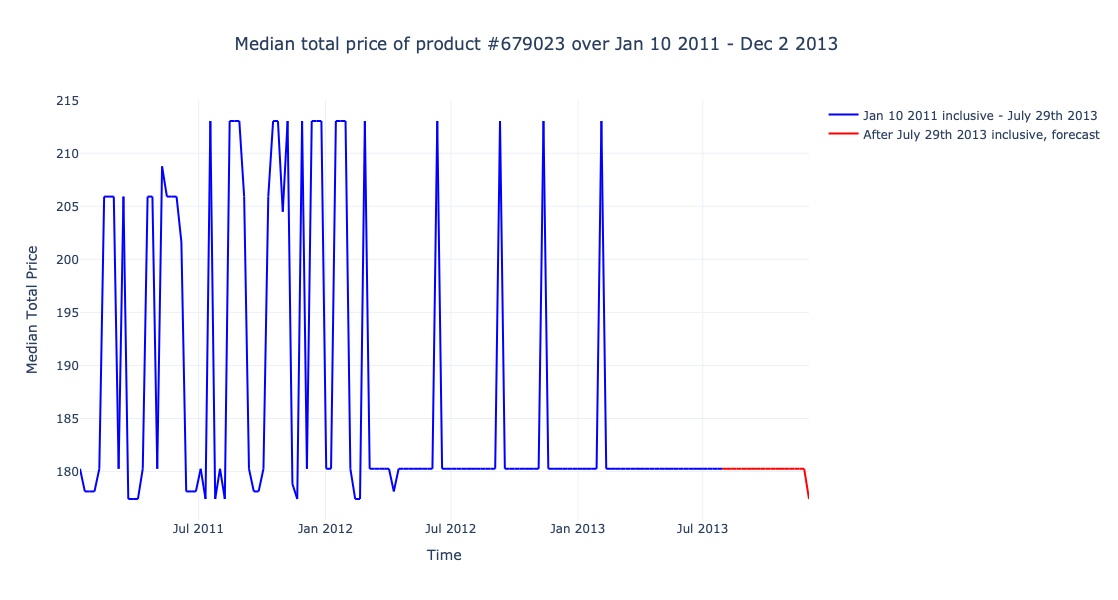

In [38]:
import itertools as it
import plotly.graph_objects as go

# generate data
pred_indices = list(range(len(median_preds)))
x = median_preds.index
y = median_preds

# cutoff value
cutoff = 132

# create coordinate  pairs
x_pairs = it.pairwise(x)
y_pairs = it.pairwise(y)

# generate color list
colors=['red' if val > cutoff else 'blue' for val in pred_indices]

#Generate names list:
names=['After July 29th 2013 inclusive, forecast' if val > cutoff else 'Jan 10 2011 inclusive - July 29th 2013' for val in pred_indices]

# create base figure
fig = go.Figure()

# add traces (line segments)
for x, y, color, name_, ele in zip(x_pairs, y_pairs, colors, names, range(len(median_preds))):
    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,          
            mode='lines',
            showlegend=True if ele == 0 or ele == 133 else False, #new colour begins for cutoff + 1
            line={'color': color},
            name=name_
        )
    )
fig.update_layout(xaxis_title="Time", 
                  yaxis_title="Median Total Price", 
                  title="Median total price of product #679023 over Jan 10 2011 - Dec 2 2013", 
                  title_x=0.75,  
                  autosize=False,
                  width=1100,
                  height=600)
#^https://community.plotly.com/t/change-color-of-continuous-line-based-on-value/68938/2
#Accessed 14/07/2024
#^https://python-graph-gallery.com/522-plotly-customize-title/
#Accessed 14/07/2024
#https://stackoverflow.com/questions/70916649/how-to-change-the-x-axis-and-y-axis-labels-in-plotly
#Accessed 14/07/2024
#^https://stackoverflow.com/questions/64448360/plotly-how-to-manually-change-the-legend-items-when-plotting-columns
#Accessed 14/07/2024

fig.write_image("/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/ml_test/679023median_total_price.png")
fig.show()

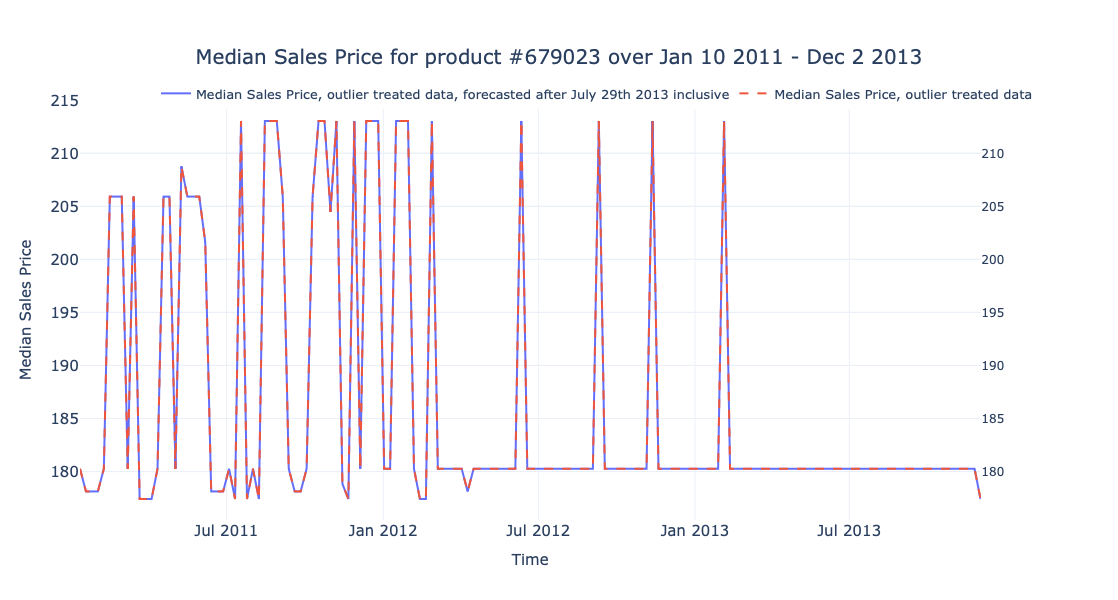

In [39]:
from src.utils import plotting_utils
#zoom_window = slice("2011-01-08", "2013-12-03")
fig = plotting_utils.two_line_plot_secondary_axis(x=ts_df.index, #or ts_df[zoom_window].index
                                   y1=ts_df[ts_df.columns.values[0]], #or ts_df[ts_df.columns.values[0]][zoom_window]
                                   y2=median_preds, #or median_preds[zoom_window]
                                   y1_name="Median Sales Price, outlier treated data, forecasted after July 29th 2013 inclusive", 
                                   y2_name="Median Sales Price, outlier treated data", 
                                   title="Median Sales Price for product #679023 over Jan 10 2011 - Dec 2 2013", 
                                   # greyscale=True,
                                  dash_secondary=True)
fig.update_layout(autosize=False,
            width=1100,
            height=600,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend=dict(
                font=dict(size=13),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text='Median Sales Price',
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ))
fig.write_image('/Users/harrybakhshi/Desktop/Python_notes/data/PCDA_capstone/ml_test/forecasted_vs_treated_data_679023median_total_price.png')
fig.show()

#^https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter03/01-Visualizing%20Time%20Series.ipynb
#Accessed 06/06/2024

# Conclusions:

- Decision Tree best model for validation set forecasting by all metrics using  hyperparameter combination (max_depth = 3, min_impurity_decrease = 0.0, min_samples_split = 2)
- Best Fit Strategy using either hyperparameter combination performs similarly on test set to Best Model on validation set, but slightly worse   
    
- Forecasted values (occuring after July 29th 2013 inclusive) of median sales price from product #679023 range from **180.2625 ≥ x ≥ 177.4125**